## CNN

In [5]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    # Input Layer
    # X is a 4-D tensor: [batch_size, width, height, channels]
    # Angio images are 23x23 pixels, and have three color channel
    #input_layer = features["x"]
    input_layer = tf.reshape(features["x"], [-1, 23, 23, 1])
    print('input_layer: ', input_layer.shape)
    
    # Convolutional Layer #1
    # Computes 64 features using a 3x3 filter, no activation function
    # Padding is added to preserve width and height
    # Input Tensor Shape: [batch_size, 23, 23, 3]
    # Output Tensor Shape: [batch_size, 23, 23, 64]
    conv1 = tf.layers.conv2d(
    inputs = input_layer,
    filters = 64,
    kernel_size = [3, 3],
    padding = "same")  
    print('conv1: ', conv1.shape)

    # Pooling Layer #1
    # Max pooling layer with a 3x3 filter and stride of 2
    # Input Tensor Shape: [batch_size, 23, 23, 64]
    # Output Tensor Shape: [batch_size, 11, 11, 64]
    pool1 = tf.layers.max_pooling2d(
    inputs = conv1,
    pool_size = [3, 3],
    strides = 2)
    print('pool1: ', pool1.shape)
    
    # Convolutional Layer #2
    # Computes 128 features using a 3x3 filter, no activation function
    # Padding is added to preserve width and height
    # Input Tensor Shape: [batch_size, 11, 11, 64]
    # Output Tensor Shape: [batch_size, 11, 11, 128]
    conv2 = tf.layers.conv2d(
    inputs = pool1,
    filters = 128,
    kernel_size = [3, 3],
    padding = "same")
    print('conv2: ', conv2.shape)
    
    # Pooling Layer #2
    # Max pooling layer with a 3x3 filter and stride of 2
    # Padding is added to preserve width and height
    # Input Tensor Shape: [batch_size, 11, 11, 128]
    # Output Tensor Shape: [batch_size, 5, 5, 128]
    pool2  = tf.layers.max_pooling2d(
    inputs = conv2,
    pool_size = [3, 3],
    strides = 2)
    print('pool2: ', pool2.shape)
    
    # Convolutional Layer #3
    # Computes 256 features using a 3x3 filter and stride of 2, no activation function
    # Padding is added to preserve width and height
    # Input Tensor Shape: [batch_size, 5, 5, 128]
    # Output Tensor Shape: [batch_size, 3, 3, 256]
    conv3 = tf.layers.conv2d(
    inputs = pool2,
    filters = 256,
    kernel_size = [3, 3],
    strides = 1,
    padding = "valid")
    print('conv3: ', conv3.shape)
    
    # Pooling Layer #3
    # Max pooling layer with a 3x3 filter
    # No padding is added.
    # Input Tensor Shape: [batch_size, 3, 3, 256]
    # Output Tensor Shape: [batch_size, 1, 1, 256]
    pool3 = tf.layers.max_pooling2d(
    inputs = conv3,
    pool_size = [3, 3],
    strides = 1)
    print('pool3: ', pool3.shape)
    
    # Flatten tensor into a batch of vectors
    # Input Tensor Shape: [batch_size, 1, 1, 256]
    # Output Tensor Shape: [batch_size, 1 * 1 * 256]
    pool2flat = tf.reshape(pool3, [-1, 1 * 1 * 256])
    print('pool2flat: ', pool2flat.shape)

    # Dense Layer
    # Densely connected layer with 256 neurons
    # Input Tensor Shape: [batch_size, 1 * 1 * 256]
    # Output Tensor Shape: [batch_size, 256]    
    dense = tf.layers.dense(
    inputs = pool2flat,
    units = 256)
    print('dense: ', dense.shape)
    
    # Logits layer
    # Input Tensor Shape: [batch_size, 256]
    # Output Tensor Shape: [batch_size, 2]
    logits = tf.layers.dense(
    inputs = dense,
    units = 2)
    print('logits: ', logits.shape)
    
    classes = tf.argmax(input = logits, axis = 1, name = "class")
    print('classes: ', classes.shape)
    probabilities = tf.nn.softmax(logits, name = "softmax_tensor")
    print('probabilities: ', probabilities.shape)
    
    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": classes,
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`
        "probabilities": probabilities
    }
    print('predictions: ', len(predictions))
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode = mode, predictions = predictions)
    
    # Calculate Loss (for both TRAIN and EVAL modes)
    #onehot_labels = tf.concat([1 - labels, labels], axis = 1)
    #print('labels: ', labels.shape)
    #print('onehot labels: ', onehot_labels.shape)
    #softmax_logits = tf.nn.softmax(logits)
    #loss = tf.losses.log_loss(labels = onehot_labels, predictions = softmax_logits)  
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    print('...Loss...')
    
    # Configure the Training Op (for TRAIN mode)
    if mode ==tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.001)
        train_op = optimizer.minimize(
            loss = loss,
            global_step = tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode = mode, loss = loss, train_op = train_op)
    
    print('labels: ', labels.shape)
    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels = labels, predictions = predictions["classes"]),
        "precision": tf.metrics.precision(
            labels = labels, predictions = predictions["classes"]),
        "recall": tf.metrics.recall(
            labels = labels, predictions = predictions["classes"]),
        "ROC": tf.metrics.auc(
            labels = labels, predictions = predictions["classes"])
    }
    return tf.estimator.EstimatorSpec(mode = mode, loss = loss, eval_metric_ops = eval_metric_ops)

## Train the model

In [2]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load training and eval data
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images  # Returns np.array
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)
eval_data = mnist.test.images  # Returns np.array
eval_labels = np.asarray(mnist.test.labels, dtype=np.int32)

count =  883402
--- 5.099962949752808 seconds ---
labels shape:  (883402, 1)
originals shape:  (883402, 23, 23)


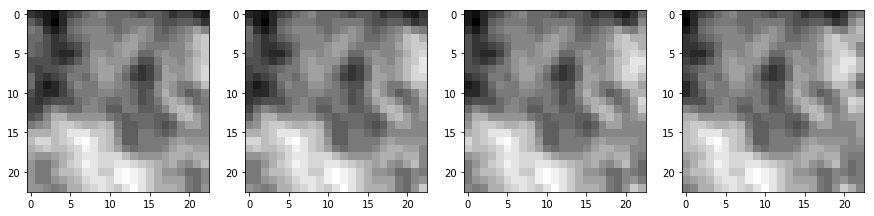

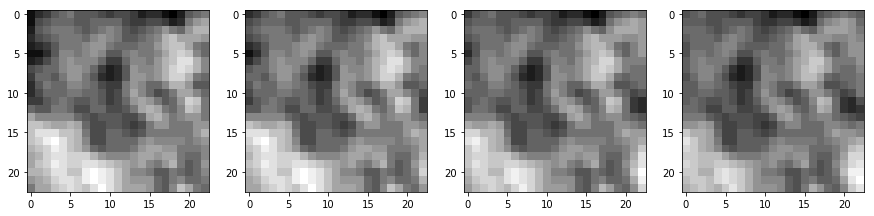

[150. 151. 150. 148. 149. 151. 154. 155.]


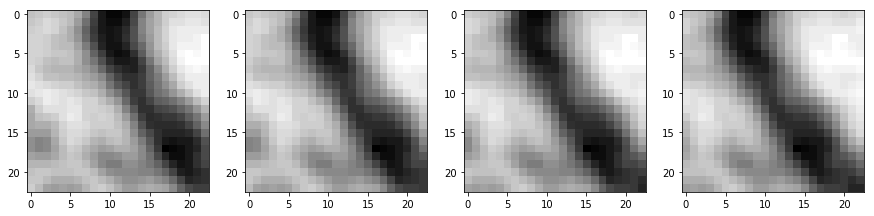

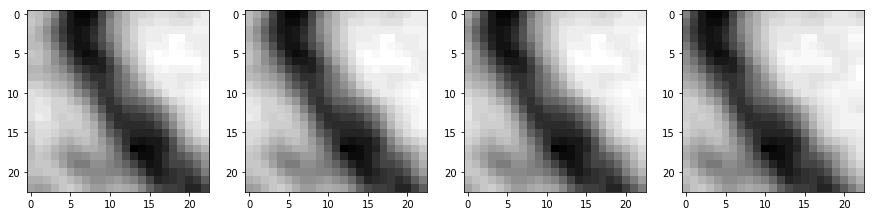

[154. 147. 140. 138. 141. 145. 146. 148.]


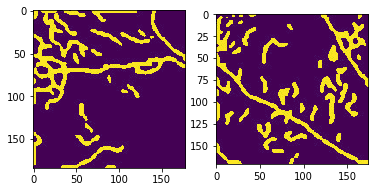

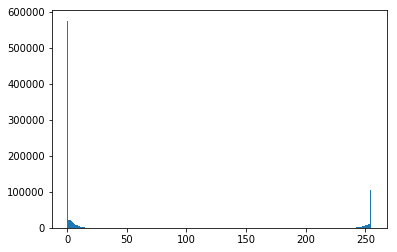

(883402, 1)
[[0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]]


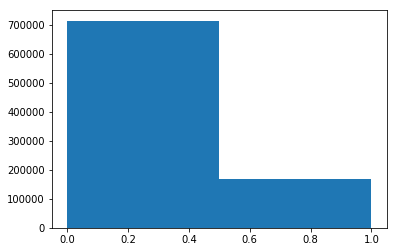

Number of negative samples:  713956
Number of positive samples:  169446
Fraction of positive samples:  19.181074980586416 %
Need to randomly choose  169446  negative samples to make it 1 : 1
338892 169446 169446
train:  271114 , test:  67778
Positive. y_train:  135557 , y_test:  33889
Negative. y_train:  135557 , y_test:  33889
(271114, 23, 23) (271114, 1)
(67778, 23, 23) (67778, 1)
Training set has mean 152.34096 and s.d. 31.447657
Standardized training set has mean -1.7445711e-05 and s.d. 1.0000018
Test set has mean 152.16481 and s.d. 31.388178
Standardized training set has mean -0.0056073037 and s.d. 0.9981076
(100, 23, 23) (100, 1)
50


In [3]:
# Load angio data
%run angio_data.ipynb

In [6]:
# Create the Estimator
angio_classifier_1 = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="/tmp/angio_model6")

# Set up logging for predictions
# Log the values in the "Softmax" tensor with label "probabilities"
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=3000)

# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train_std},
    y=y_train,
    #x={"x": train_data},
    #y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True)
angio_classifier_1.train(
    input_fn=train_input_fn,
    steps=12000,
    hooks=[logging_hook])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/angio_model6', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x18e2c53b70>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
input_layer:  (100, 23, 23, 1)
conv1:  (100, 23, 23, 64)
pool1:  (100, 11, 11, 64)
conv2:  (100, 11, 11, 128)
pool2:  (100, 5, 5, 128)
conv3:  (100, 3, 3, 256)
pool3:  (100, 1, 1, 256)
pool2flat:  (100, 256)
dense:  (100, 256)
logits:  (100, 2)
classes:  (100,)
probabilities:  (100, 2)
predictions:  2
...Loss...
INFO:tensorflow:Done

INFO:tensorflow:loss = 0.65903866, step = 3001 (18.226 sec)
INFO:tensorflow:global_step/sec: 5.93904
INFO:tensorflow:loss = 0.67128015, step = 3101 (16.832 sec)
INFO:tensorflow:global_step/sec: 6.00049
INFO:tensorflow:loss = 0.662849, step = 3201 (16.665 sec)
INFO:tensorflow:global_step/sec: 5.73644
INFO:tensorflow:loss = 0.65884703, step = 3301 (17.432 sec)
INFO:tensorflow:global_step/sec: 5.898
INFO:tensorflow:loss = 0.66923463, step = 3401 (16.955 sec)
INFO:tensorflow:global_step/sec: 5.98231
INFO:tensorflow:loss = 0.6584721, step = 3501 (16.718 sec)
INFO:tensorflow:global_step/sec: 6.04993
INFO:tensorflow:loss = 0.65828353, step = 3601 (16.528 sec)
INFO:tensorflow:global_step/sec: 6.03173
INFO:tensorflow:loss = 0.657631, step = 3701 (16.578 sec)
INFO:tensorflow:global_step/sec: 6.03261
INFO:tensorflow:loss = 0.6618438, step = 3801 (16.577 sec)
INFO:tensorflow:global_step/sec: 5.89936
INFO:tensorflow:loss = 0.6613314, step = 3901 (16.951 sec)
INFO:tensorflow:global_step/sec: 6.04056

INFO:tensorflow:global_step/sec: 5.95
INFO:tensorflow:loss = 0.544478, step = 8601 (16.807 sec)
INFO:tensorflow:global_step/sec: 6.07971
INFO:tensorflow:loss = 0.57800823, step = 8701 (16.448 sec)
INFO:tensorflow:global_step/sec: 5.7295
INFO:tensorflow:loss = 0.57109123, step = 8801 (17.454 sec)
INFO:tensorflow:global_step/sec: 5.64511
INFO:tensorflow:loss = 0.5465233, step = 8901 (17.715 sec)
INFO:tensorflow:global_step/sec: 6.05389
INFO:tensorflow:probabilities = [[0.22011669 0.7798833 ]
 [0.3677419  0.63225806]
 [0.5342591  0.46574095]
 [0.46322322 0.5367767 ]
 [0.951423   0.04857706]
 [0.13235986 0.86764014]
 [0.32148772 0.6785123 ]
 [0.30003968 0.69996035]
 [0.46726134 0.5327387 ]
 [0.45260423 0.5473958 ]
 [0.44369492 0.55630505]
 [0.7298107  0.27018932]
 [0.07257827 0.9274217 ]
 [0.4320681  0.56793183]
 [0.11988449 0.8801155 ]
 [0.5389928  0.4610072 ]
 [0.78366566 0.21633439]
 [0.45896557 0.54103434]
 [0.18859287 0.81140715]
 [0.62856716 0.37143293]
 [0.22951804 0.770482  ]
 [0.4

In [7]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_test_std},
    y=y_test,
    #x={"x": eval_data},
    #y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = angio_classifier_1.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
input_layer:  (?, 23, 23, 1)
conv1:  (?, 23, 23, 64)
pool1:  (?, 11, 11, 64)
conv2:  (?, 11, 11, 128)
pool2:  (?, 5, 5, 128)
conv3:  (?, 3, 3, 256)
pool3:  (?, 1, 1, 256)
pool2flat:  (?, 256)
dense:  (?, 256)
logits:  (?, 2)
classes:  (?,)
probabilities:  (?, 2)
predictions:  2
...Loss...
labels:  (?, 1)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-25-13:20:24
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/angio_model6/model.ckpt-12000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-25-13:20:53
INFO:tensorflow:Saving dict for global step 12000: ROC = 0.7549205, accuracy = 0.7549205, global_step = 12000, loss = 0.52337587, precision = 0.7904842, recall = 0.6937059
{'ROC': 0.7549205, 'accuracy': 0.7549205, 'loss': 0.52337587, 'precision': 0.7904842, 'recall': 0.6937059, 'global_step': 12000}
